# Ovarian Cancer Subtype Identification

This Kaggle notebook addresses the critical task of accurately identifying ovarian cancer subtypes using histopathology images. Ovarian carcinoma, the most lethal cancer of the female reproductive system, has distinct subtypes with unique characteristics.

The competition, hosted by the University of British Columbia (UBC) and supported by BC Cancer and the Ovarian Tumour Tissue Analysis (OTTA) consortium, provides a diverse dataset from over 20 centers across four continents.

The objective is to develop a deep learning model that improves accuracy in subtype classification, aiming to overcome challenges in current diagnostic methods and leverage the potential of deep learning in histopathology analysis.

Let's dive into the exploration, preprocessing, and development of a model to contribute to more effective personalized treatment strategies for ovarian cancer patients.

In [1]:
import os
import random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms
import numpy as np
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from IPython.display import display, HTML

def show_data(data_sample, shape = (200,200)):
  plt.imshow(data_sample[0].permute(1, 2, 0).numpy())
  plt.title(f'y = {data_sample[1]}')
    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda', index=0)

In [2]:
data_dir = '/kaggle/input/UBC-OCEAN/train_thumbnails'
csv_dir = '/kaggle/input/UBC-OCEAN/train.csv'
data_name = pd.read_csv(csv_dir)
data_name.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [3]:
unique_labels = data_name.iloc[:, 1].unique()
labels_dict = {}
for i, j in enumerate(unique_labels):
    labels_dict[j] = i
    
labels_dict

{'HGSC': 0, 'LGSC': 1, 'EC': 2, 'CC': 3, 'MC': 4}

## Creating Dataset & Removing Outliers

In [4]:
class UBCDataset(Dataset):
    def __init__(self, data_dir, csv_dir, labels_dict, labels=labels_dict.keys(), transform=None, train=True, seed=1, n=10):
        self.data_dir = data_dir
        self.labels = labels
        self.labels_dict = labels_dict
        self.csv_dir = csv_dir
        self.transform = transform
        self.data_info = pd.read_csv(csv_dir)
        self.data_info['image_path'] = self.data_info['image_id'].apply(lambda x: os.path.join(data_dir, f"{x}_thumbnail.png"))
        self.data_info = self.data_info[self.data_info['image_path'].apply(os.path.exists)]
        self.data_info = self.data_info[self.data_info['label'].isin(labels)]
        
        random.seed(seed)
        indices = list(range(len(self.data_info)))
        random.shuffle(indices)

        split_index = int(0.7 * len(indices))  # Adjust the split ratio as needed
        if train:
            indices_to_use = indices[:split_index]  # Use the first part for training
        else:
            indices_to_use = indices[split_index:]  # Use the latter part for testing
        
        self.data_info = self.data_info.iloc[indices_to_use]

        if train:
            self.data_info = pd.concat([self.data_info] * n, ignore_index=True)

        self.label_counts = {}

        for label in self.data_info.iloc[:, 1]:
            if label in self.label_counts:
                self.label_counts[label] += 1
            else:
                self.label_counts[label] = 1

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, index):
        image_path = self.data_info.iloc[index, 5]  
        image = Image.open(image_path)
        label = self.labels_dict.get(self.data_info.iloc[index, 1], -1)
        if self.transform:
            image = self.transform(image)
        return image, label

# DATASETS & Transforms

In [5]:
IMAGE_SIZE = 704
transform = transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()
                                ])

aug_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(-10, 10)),  # Randomly rotate by -10 to 10 degrees
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),    # Vertical flip
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.5, 1.0)),  # Random scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),  # Gaussian blur
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [6]:
train_set_org = UBCDataset(data_dir, csv_dir, labels_dict,transform=transform, train = True, n = 1)
validation_set = UBCDataset(data_dir, csv_dir, labels_dict, transform=transform, train = False)
print(f'Size of Train Data = {len(train_set_org)}')
print(f'Size of Validation Data = {len(validation_set)}')
print(f'Size of Train + Validation = {len(train_set_org) + len(validation_set)}')

Size of Train Data = 359
Size of Validation Data = 154
Size of Train + Validation = 513


# Train and Validation Dataset Class Distribution

Visualizing the distribution of classes in the training and validation datasets provides insights into the balance and representation of each ovarian cancer subtype.

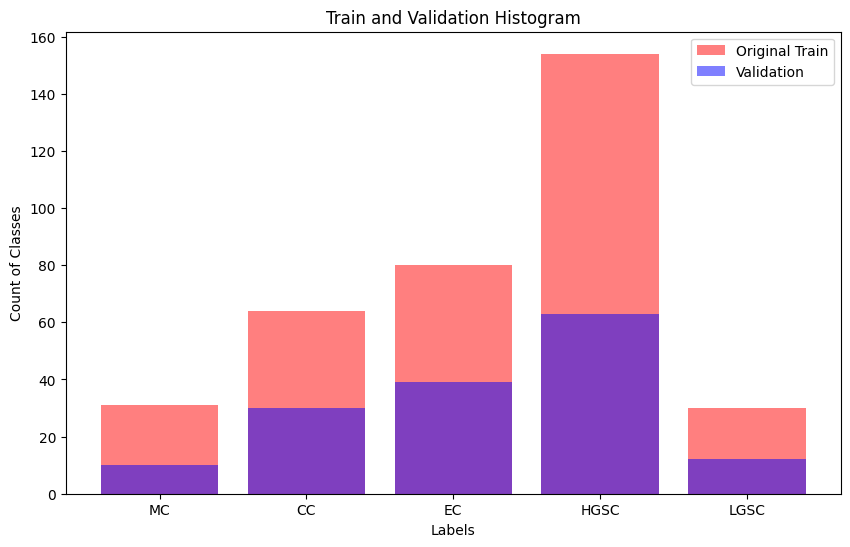

In [7]:
train_label_counts = train_set_org.label_counts
validation_label_counts = validation_set.label_counts
plt.figure(figsize=(10, 6))
plt.bar(train_label_counts.keys(), train_label_counts.values(), color='r', alpha=0.5, label='Original Train')
plt.bar(validation_label_counts.keys(), validation_label_counts.values(), color='b', alpha=0.5, label='Validation')
plt.xlabel('Labels')
plt.ylabel('Count of Classes')
plt.title('Train and Validation Histogram')
plt.legend()
plt.show()

# Dataset Creation for Ovarian Cancer Subtypes

We create specialized datasets for different ovarian cancer subtypes, incorporating data augmentation for enhanced model robustness. The datasets include:


In [8]:
train_HGSC = UBCDataset(data_dir, csv_dir, labels_dict, labels = ['HGSC'], transform=aug_transform, train = True, n = 6)
train_CC_EC = UBCDataset(data_dir, csv_dir, labels_dict, labels = ['CC', 'EC'], transform=aug_transform, train = True, n = 6)
train_LGSC_MC = UBCDataset(data_dir, csv_dir, labels_dict, labels = ['LGSC', 'MC'], transform=aug_transform, train = True, n = 10)
train_set = ConcatDataset([train_set_org, train_HGSC, train_CC_EC, train_LGSC_MC])

In [9]:
train_loader = DataLoader(train_set, batch_size = 16, shuffle=True, 
                          pin_memory=True
                         )
validation_loader = DataLoader(validation_set, batch_size = 16)

# Sample Images from the Original Training and Validation Dataset

Displaying a subset of sample images from the original training and validation dataset provides a visual representation of the histopathology images used for model training.

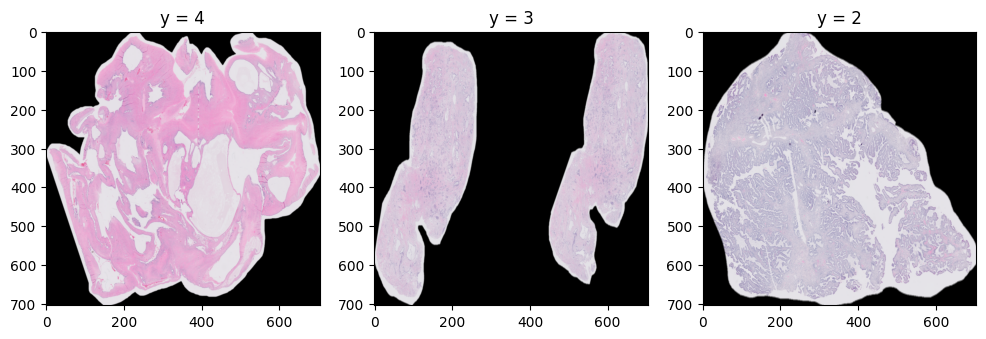

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(train_set_org[i])
plt.show()

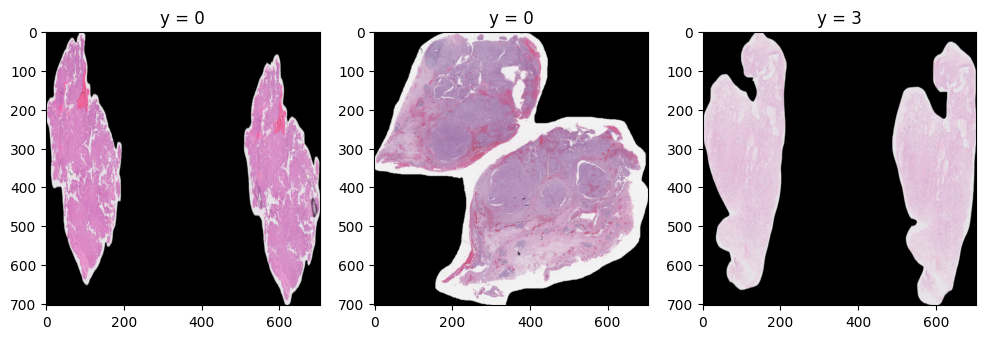

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(validation_set[i])
plt.show()

# CustomResNet: Ovarian Cancer Subtype Identification Model

The `CustomResNet` class defines a custom deep learning model for the identification of ovarian cancer subtypes. The model is based on the ResNet-50 architecture and includes additional fully connected layers for classification.

In [12]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [13]:
model = CustomResNet(5).to(device)
criterion = nn.CrossEntropyLoss()
weight_decay = 0.001
optimizer = optim.Adam(
    model.parameters(), 
    lr = 1e-5, 
    weight_decay = weight_decay
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s] 


# Training Function
The `train_model` function defines the training process for the ovarian cancer subtype identification model. It includes the training and validation phases, tracking loss and accuracy over multiple epochs.

In [14]:
epochs = 25
train_loss_list = []
validation_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []  
def train_model(model, train_loader, validation_loader, optimizer, criterion, epochs):
    N_train = len(train_loader.dataset)
    N_validation = len(validation_loader.dataset)

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_correct = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat_train = model(x)
            loss = criterion(yhat_train, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            _, yhat_max = torch.max(yhat_train, 1)
            epoch_train_correct += (yhat_max == y).sum().item()
        
        # Validation phase
        model.eval()
        epoch_validation_loss = 0.0
        epoch_validation_correct = 0
        with torch.no_grad():
            for x_cv, y_cv in validation_loader:
                x_cv, y_cv = x_cv.to(device), y_cv.to(device)
                yhat_validation = model(x_cv)
                loss = criterion(yhat_validation, y_cv)
                epoch_validation_loss += loss.item()
                _, yhat_max = torch.max(yhat_validation, 1)
                epoch_validation_correct += (yhat_max == y_cv).sum().item()
        

        train_loss = epoch_train_loss / N_train
        train_accuracy = epoch_train_correct / N_train
        validation_loss = epoch_validation_loss / N_validation
        validation_accuracy = epoch_validation_correct / N_validation
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)

        print(f'Epoch: {epoch} | Train Loss: {train_loss} | Validation Loss: {validation_loss} | Train Accuracy: {train_accuracy} | Validation Accuracy: {validation_accuracy}')

In [15]:
train_model(model, train_loader, validation_loader, optimizer, criterion, epochs)

Epoch: 0 | Train Loss: 0.10091738846233267 | Validation Loss: 0.0925104587109058 | Train Accuracy: 0.2646951442132165 | Validation Accuracy: 0.44805194805194803
Epoch: 1 | Train Loss: 0.08878963112874638 | Validation Loss: 0.07433744645737983 | Train Accuracy: 0.4194961664841183 | Validation Accuracy: 0.6168831168831169
Epoch: 2 | Train Loss: 0.0784388782334789 | Validation Loss: 0.06663956077067883 | Train Accuracy: 0.5144213216502374 | Validation Accuracy: 0.6428571428571429
Epoch: 3 | Train Loss: 0.07136046597016646 | Validation Loss: 0.05993755877792061 | Train Accuracy: 0.597663380795911 | Validation Accuracy: 0.6948051948051948
Epoch: 4 | Train Loss: 0.06414152438643206 | Validation Loss: 0.05263211510398171 | Train Accuracy: 0.6480467323840818 | Validation Accuracy: 0.7467532467532467
Epoch: 5 | Train Loss: 0.05957554016900176 | Validation Loss: 0.04993137407612491 | Train Accuracy: 0.6710478276743337 | Validation Accuracy: 0.7662337662337663
Epoch: 6 | Train Loss: 0.05586797142

# Training Metrics Visualization

The plots below illustrate the training progress of the ovarian cancer subtype identification model over multiple epochs. Two subplots depict changes in loss and accuracy.

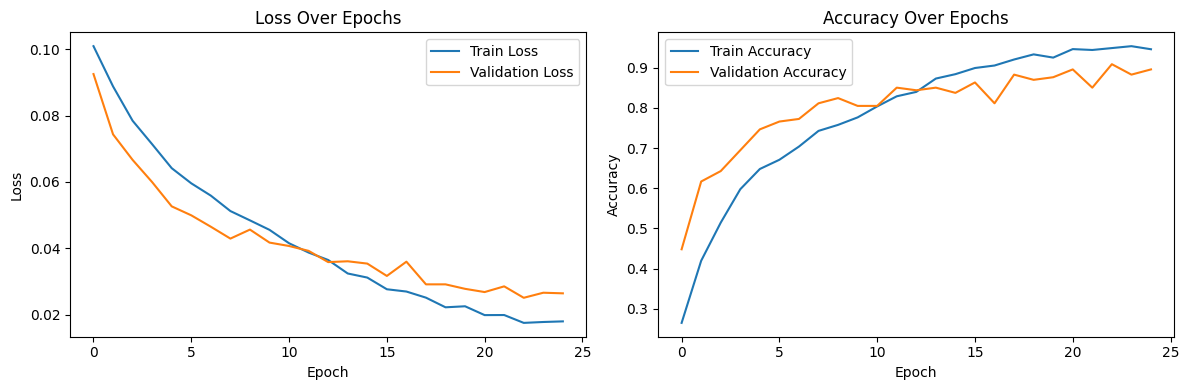

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(epochs), train_loss_list, label='Train Loss')
axs[0].plot(range(epochs), validation_loss_list, label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(range(epochs), train_accuracy_list, label='Train Accuracy')
axs[1].plot(range(epochs), validation_accuracy_list, label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

# Overall Model Metrics Evaluation

The `calculate_overall_metrics` function assesses the overall performance of the ovarian cancer subtype identification model on the validation dataset. The function computes precision, recall, and F1-score, providing a comprehensive view of the model's classification performance.

In [17]:
def calculate_overall_metrics(model, data_loader):
    num_classes = len(labels_dict.values())
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            yhat = model(x)
            _, yhat_max = torch.max(yhat, 1)

            all_labels.extend(y.cpu().numpy())
            all_predictions.extend(yhat_max.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f'Overall Precision: {precision}')
    print(f'Overall Recall: {recall}')
    print(f'Overall F1-Score: {f1_score}')
    
calculate_overall_metrics(model, validation_loader)

Overall Precision: 0.8998880775868123
Overall Recall: 0.8961038961038961
Overall F1-Score: 0.8958140704731347


# Class-wise Model Accuracy Evaluation

The `calculate_class_accuracy` function evaluates the model's accuracy for each individual class on the validation dataset. It provides a detailed classification report, including precision, recall, and F1-score for each class.

In [18]:
def calculate_class_accuracy(model, data_loader):
    num_classes = len(labels_dict.values())
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            yhat = model(x)
            _, yhat_max = torch.max(yhat, 1)

            all_labels.extend(y.cpu().numpy())
            all_predictions.extend(yhat_max.cpu().numpy())

    report = classification_report(all_labels, all_predictions, target_names=[f'Class {list(labels_dict.keys())[i]}' for i in range(num_classes)])
    print(report)
    
calculate_class_accuracy(model, validation_loader)

              precision    recall  f1-score   support

  Class HGSC       0.87      0.95      0.91        63
  Class LGSC       0.82      0.75      0.78        12
    Class EC       0.97      0.85      0.90        39
    Class CC       0.87      0.90      0.89        30
    Class MC       1.00      0.90      0.95        10

    accuracy                           0.90       154
   macro avg       0.91      0.87      0.89       154
weighted avg       0.90      0.90      0.90       154



## *Save Model*

In [19]:
# model_path = '/kaggle/working/ovarian_cancer_classifier_model.pth'
# torch.save(model.state_dict(), model_path)

# Submission

The following code snippet demonstrates the process of generating predictions on the test set using the trained model and submitting the results.

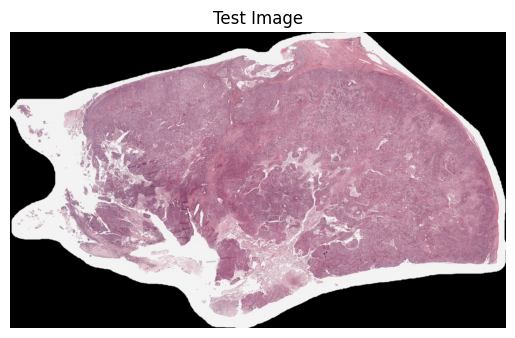

In [20]:
inverse_labels_dict = {v: k for k, v in labels_dict.items()}
image_test = Image.open('/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png')
img_tfm = aug_transform(image_test).unsqueeze(0).to(device)
plt.title('Test Image')
plt.imshow(image_test)
plt.axis('off')
plt.show()
test_probabilities = torch.softmax(model(img_tfm), 1) * 100
probabilities_list = test_probabilities.squeeze().tolist()
font_size = 20
html_text = "<div style='font-size: {}px;'>".format(font_size)
for class_idx, class_label in inverse_labels_dict.items():
    html_text += f"{class_label}: {probabilities_list[class_idx]:.2f}%<br>"
html_text += "</div>"
display(HTML(html_text))

In [21]:
model.eval()
a, b = torch.max(model(img_tfm), 1)
b = b.item()
test_df = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')
output_df = pd.DataFrame({
    'image_id': test_df['image_id'],
    'label': inverse_labels_dict[b]
})
output_df.to_csv('/kaggle/working/submission.csv', index=False)
output_df.head()

,image_id,label
0,41,HGSC
